In [232]:
import boto3
from dotenv import load_dotenv
import os
# Initialize an S3 client
s3_client = boto3.client('s3')


load_dotenv()

# Access the environment variables for AWS credentials
AWS_ACCESS_KEY_ID = os.getenv('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.getenv('AWS_SECRET_ACCESS_KEY')
AWS_DEFAULT_REGION = os.getenv('AWS_DEFAULT_REGION')

s3_client = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_DEFAULT_REGION
)

# Define the S3 bucket and the file path
bucket_name = 'isbfinanceproject'
def get_file_path(vertical, ticker):
    file_path = f"{vertical}/{ticker}/{ticker}_data.csv"
    return file_path

# Example usage
vertical = 'Energy'  # Replace with the actual vertical
ticker = 'RELIANCE.NS'       # Replace with the actual ticker

# Get the file path
file_path = get_file_path(vertical, ticker)

# Download the file to the local system
try:
    s3_client.download_file(bucket_name, file_path, f"./{ticker}_data.csv")
    print(f"File {ticker}_data.csv downloaded successfully.")
except Exception as e:
    print(f"Error downloading file: {e}")

File RELIANCE.NS_data.csv downloaded successfully.


In [233]:
import pandas as pd
df = pd.read_csv(f"./{ticker}_data.csv")
df = df.drop([0, 1])
df = df.reset_index(drop=True)
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume,P/E Ratio,Beta (5Y Monthly),Market Cap,Forward P/E,EPS (TTM),Price.1,Sector,Industry
0,2019-11-18 00:00:00+00:00,646.4679565429688,667.09716796875,679.3491821289062,665.3599243164062,673.2460327148438,14076051,25.250996,0.635,1.715367e+13,19.849545,50.2,1252.05,Energy,Oil & Gas Refining & Marketing
1,2019-11-19 00:00:00+00:00,668.8631591796875,690.2069091796875,692.5613403320312,669.7487182617188,670.6630249023438,30176255,25.250996,0.635,1.715367e+13,19.849545,50.2,1252.05,Energy,Oil & Gas Refining & Marketing
2,2019-11-20 00:00:00+00:00,685.6538696289062,707.5335083007812,718.848388671875,705.4991455078125,710.9165649414062,43538120,25.250996,0.635,1.715367e+13,19.849545,50.2,1252.05,Energy,Oil & Gas Refining & Marketing
3,2019-11-21 00:00:00+00:00,681.2014770507812,702.93896484375,711.350830078125,698.8016357421875,706.322021484375,14897371,25.250996,0.635,1.715367e+13,19.849545,50.2,1252.05,Energy,Oil & Gas Refining & Marketing
4,2019-11-22 00:00:00+00:00,685.1444702148438,707.0077514648438,717.5225830078125,702.93896484375,704.9962158203125,22352865,25.250996,0.635,1.715367e+13,19.849545,50.2,1252.05,Energy,Oil & Gas Refining & Marketing


In [234]:
data = df[['Price']].copy()
df=df.drop(columns=['Price'])

In [235]:

df['Adj Close'] = pd.to_numeric(df['Adj Close'], errors='coerce')
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

Noise Reduction (Removing Outliers & Irrelevant Data):

In [236]:
print(df.dtypes)

Adj Close            float64
Close                float64
High                 float64
Low                  float64
Open                 float64
Volume                 int64
P/E Ratio            float64
Beta (5Y Monthly)    float64
Market Cap           float64
Forward P/E          float64
EPS (TTM)            float64
Price.1              float64
Sector                object
Industry              object
dtype: object


In [237]:
# Identify outliers using the Z-score method (e.g., 3 standard deviations away from the mean)
from scipy.stats import zscore

# Calculate Z-scores for the relevant columns (e.g., 'Close' price)
df['zscore'] = zscore(df['Close'])

# Filter out rows where the z-score is beyond 3 (or any threshold you prefer)
df_filtered = df[df['zscore'].abs() < 3]

Feature Engineering:


a. Lagged Stock Prices (Previous Day’s Price):

Essentially shift the stock's price by a certain number of time periods (e.g., days), which allows to incorporate past information into the model.

Example:
lag_1: The stock price on the previous day (shift(1))
lag_2: The stock price from two days ago (shift(2))
lag_7: The stock price from seven days ago (shift(7))


In [238]:
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_7'] = df['Close'].shift(7)

Moving average (7-day and 30-day)

In [239]:
df['ma_7'] = df['Close'].rolling(window=7).mean()
df['ma_30'] = df['Close'].rolling(window=30).mean()

Volatility indicators

In [240]:
df['daily_returns'] = df['Close'].pct_change()
df['volatility'] = df['daily_returns'].rolling(window=30).std()  # 30-day volatility

Check if data is normally distributed for z-score standardization

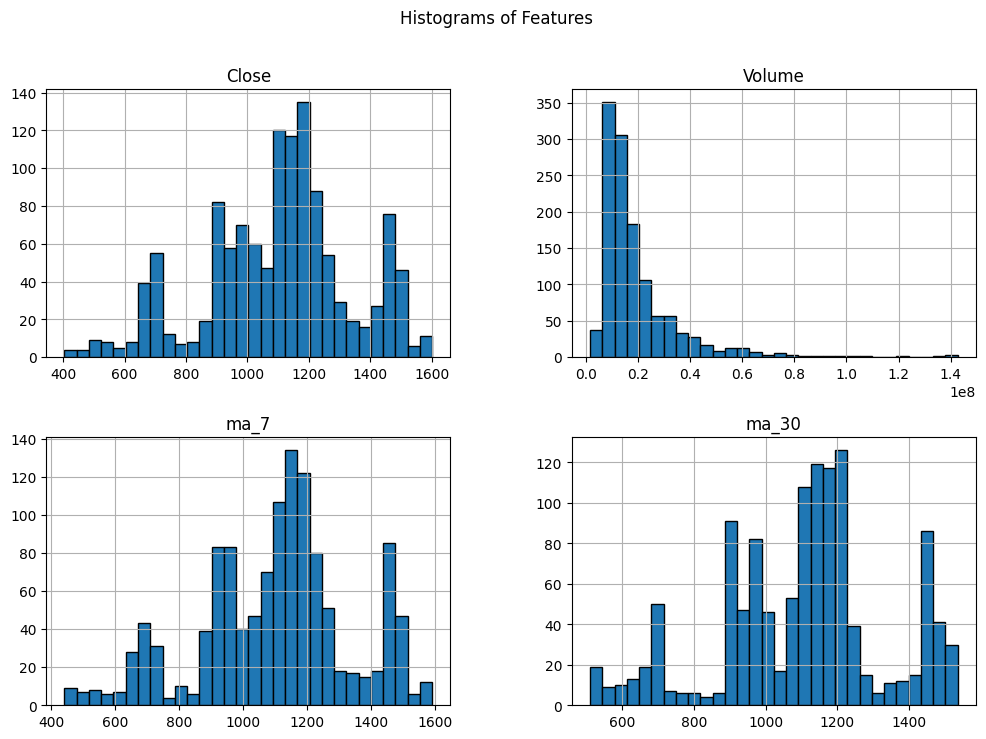

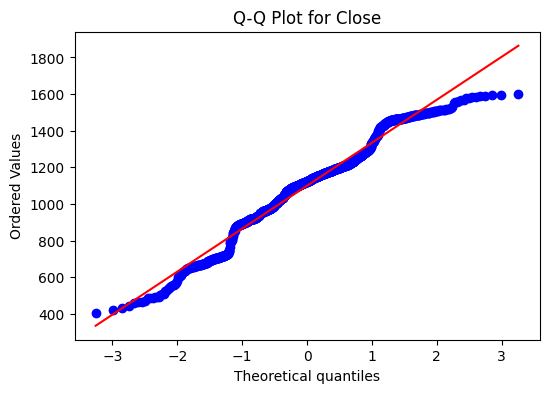

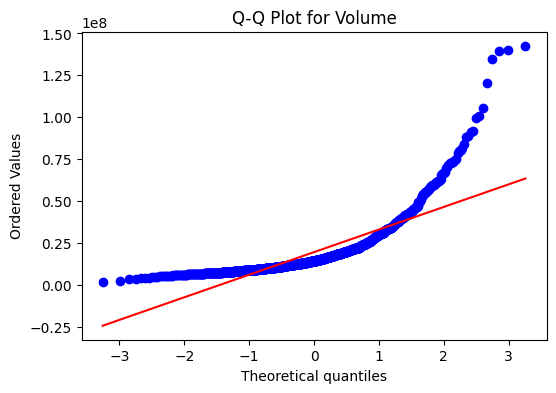

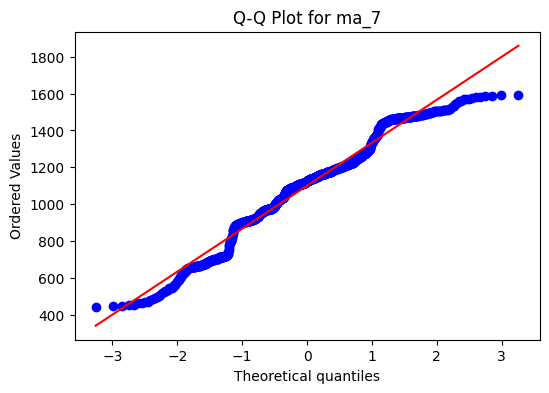

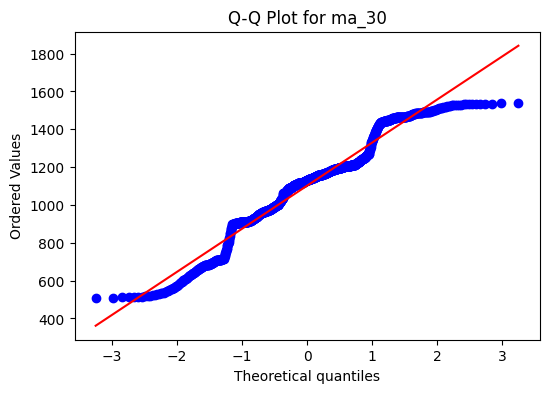

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Plot histograms for each of the features
features = ['Close', 'Volume', 'ma_7', 'ma_30']
df[features].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle('Histograms of Features')
plt.show()

# Q-Q plot for normality
for feature in features:
    plt.figure(figsize=(6, 4))
    stats.probplot(df[feature].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {feature}')
    plt.show()

In [242]:
from scipy.stats import shapiro, kstest

# Shapiro-Wilk test for normality
for feature in features:
    stat, p_value = shapiro(df[feature].dropna())
    print(f'Shapiro-Wilk test for {feature}:')
    print(f'Statistic={stat}, p-value={p_value}')
    if p_value > 0.05:
        print(f'{feature} is normally distributed (fail to reject H0)\n')
    else:
        print(f'{feature} is not normally distributed (reject H0)\n')

# Kolmogorov-Smirnov test for normality
for feature in features:
    stat, p_value = kstest(df[feature].dropna(), 'norm')
    print(f'KS test for {feature}:')
    print(f'Statistic={stat}, p-value={p_value}')
    if p_value > 0.05:
        print(f'{feature} is normally distributed (fail to reject H0)\n')
    else:
        print(f'{feature} is not normally distributed (reject H0)\n')

Shapiro-Wilk test for Close:
Statistic=0.9754533527360119, p-value=1.142731996335971e-13
Close is not normally distributed (reject H0)

Shapiro-Wilk test for Volume:
Statistic=0.6964975887571252, p-value=1.687385994566904e-42
Volume is not normally distributed (reject H0)

Shapiro-Wilk test for ma_7:
Statistic=0.9726519570784962, p-value=1.619798796791955e-14
ma_7 is not normally distributed (reject H0)

Shapiro-Wilk test for ma_30:
Statistic=0.9624087469219206, p-value=3.915855813433725e-17
ma_30 is not normally distributed (reject H0)

KS test for Close:
Statistic=1.0, p-value=0.0
Close is not normally distributed (reject H0)

KS test for Volume:
Statistic=1.0, p-value=0.0
Volume is not normally distributed (reject H0)

KS test for ma_7:
Statistic=1.0, p-value=0.0
ma_7 is not normally distributed (reject H0)

KS test for ma_30:
Statistic=1.0, p-value=0.0
ma_30 is not normally distributed (reject H0)



As from the data the features are not normally distributed hence we use min-max scaler

In [243]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Close', 'Volume', 'ma_7', 'ma_30','High', 'Low', 'Open', 'lag_1','lag_2', 'lag_7', 'daily_returns', 'volatility']] = scaler.fit_transform(
    df[['Close', 'Volume', 'ma_7', 'ma_30', 'High', 'Low', 'Open', 'lag_1','lag_2', 'lag_7','daily_returns', 'volatility']])

In [244]:
data

,Price
0,2019-11-18 00:00:00+00:00
1,2019-11-19 00:00:00+00:00
2,2019-11-20 00:00:00+00:00
3,2019-11-21 00:00:00+00:00
4,2019-11-22 00:00:00+00:00
...,...
1234,2024-11-08 00:00:00+00:00
1235,2024-11-11 00:00:00+00:00
1236,2024-11-12 00:00:00+00:00
1237,2024-11-13 00:00:00+00:00


In [245]:
df['Price'] = data['Price'] 

In [246]:
df['Price'] = pd.to_datetime(df['Price'])
print(df.columns)
# Set the 'Date' column as the index
df.rename(columns={'Price': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)



Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'P/E Ratio',
       'Beta (5Y Monthly)', 'Market Cap', 'Forward P/E', 'EPS (TTM)',
       'Price.1', 'Sector', 'Industry', 'zscore', 'lag_1', 'lag_2', 'lag_7',
       'ma_7', 'ma_30', 'daily_returns', 'volatility', 'Price'],
      dtype='object')


In [247]:
df

,Adj Close,Close,High,Low,Open,Volume,P/E Ratio,Beta (5Y Monthly),Market Cap,Forward P/E,...,Sector,Industry,zscore,lag_1,lag_2,lag_7,ma_7,ma_30,daily_returns,volatility
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-18 00:00:00+00:00,646.467957,0.219713,0.208636,0.223630,0.214568,0.087747,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,-1.826311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-19 00:00:00+00:00,668.863159,0.239023,0.219885,0.227333,0.212389,0.201951,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,-1.728735,0.219713,NaN,NaN,NaN,NaN,0.596231,NaN
2019-11-20 00:00:00+00:00,685.653870,0.253501,0.242267,0.257497,0.246341,0.296731,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,-1.655578,0.239023,0.219713,NaN,NaN,NaN,0.562008,NaN
2019-11-21 00:00:00+00:00,681.201477,0.249662,0.235883,0.251846,0.242466,0.093573,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,-1.674977,0.253501,0.239023,NaN,NaN,NaN,0.448642,NaN
2019-11-22 00:00:00+00:00,685.144470,0.253062,0.241138,0.255337,0.241348,0.146457,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,-1.657798,0.249662,0.253501,NaN,NaN,NaN,0.492708,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08 00:00:00+00:00,1283.750000,0.734989,0.738483,0.738015,0.741227,0.128451,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,0.777366,0.753289,0.769750,0.785250,0.758305,0.829838,0.411761,0.118240
2024-11-11 00:00:00+00:00,1272.699951,0.725755,0.725158,0.731265,0.725454,0.052142,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,0.730709,0.734989,0.753289,0.775348,0.750933,0.821611,0.441058,0.106180
2024-11-12 00:00:00+00:00,1274.250000,0.727051,0.727967,0.731687,0.722586,0.063595,25.250996,0.635,1.715367e+13,19.849545,...,Energy,Oil & Gas Refining & Marketing,0.737254,0.725755,0.734989,0.780863,0.742933,0.815043,0.476310,0.090960


In [248]:
features = ['Close', 'Volume', 'ma_7', 'ma_30', 'High', 'Low', 'Open', 'lag_1', 'lag_2', 'lag_7', 'daily_returns', 'volatility']
df = df[features]

In [249]:
from sklearn.model_selection import train_test_split

# Assuming df_filtered is your DataFrame

# First, split the data into 70% training and 30% temporary (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Now, split the temp_df into 50% validation and 50% test, so that each becomes 15% of the total data
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Check the sizes of each dataset
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 867
Validation set size: 186
Test set size: 186


In [250]:
# Replace NaN values with 0 for the entire DataFrame
df = df.fillna(0)

# Check if NaN values have been replaced
print(df.isna().sum())

Close            0
Volume           0
ma_7             0
ma_30            0
High             0
Low              0
Open             0
lag_1            0
lag_2            0
lag_7            0
daily_returns    0
volatility       0
dtype: int64


In [251]:
df

,Close,Volume,ma_7,ma_30,High,Low,Open,lag_1,lag_2,lag_7,daily_returns,volatility
Date,,,,,,,,,,,,
2019-11-18 00:00:00+00:00,0.219713,0.087747,0.000000,0.000000,0.208636,0.223630,0.214568,0.000000,0.000000,0.000000,0.000000,0.000000
2019-11-19 00:00:00+00:00,0.239023,0.201951,0.000000,0.000000,0.219885,0.227333,0.212389,0.219713,0.000000,0.000000,0.596231,0.000000
2019-11-20 00:00:00+00:00,0.253501,0.296731,0.000000,0.000000,0.242267,0.257497,0.246341,0.239023,0.219713,0.000000,0.562008,0.000000
2019-11-21 00:00:00+00:00,0.249662,0.093573,0.000000,0.000000,0.235883,0.251846,0.242466,0.253501,0.239023,0.000000,0.448642,0.000000
2019-11-22 00:00:00+00:00,0.253062,0.146457,0.000000,0.000000,0.241138,0.255337,0.241348,0.249662,0.253501,0.000000,0.492708,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-08 00:00:00+00:00,0.734989,0.128451,0.758305,0.829838,0.738483,0.738015,0.741227,0.753289,0.769750,0.785250,0.411761,0.118240
2024-11-11 00:00:00+00:00,0.725755,0.052142,0.750933,0.821611,0.725158,0.731265,0.725454,0.734989,0.753289,0.775348,0.441058,0.106180
2024-11-12 00:00:00+00:00,0.727051,0.063595,0.742933,0.815043,0.727967,0.731687,0.722586,0.725755,0.734989,0.780863,0.476310,0.090960


In [252]:
train_df

,Close,Volume,ma_7,ma_30,High,Low,Open,lag_1,lag_2,lag_7,daily_returns,volatility
Date,,,,,,,,,,,,
2021-06-01 00:00:00+00:00,0.498678,0.186612,0.437236,0.389928,0.495461,0.498060,0.489841,0.495362,0.470103,0.434529,0.486223,0.150142
2023-04-05 00:00:00+00:00,0.559203,0.103259,0.528555,0.542862,0.552829,0.561161,0.560686,0.561362,0.561208,0.529104,0.463323,0.143440
2021-11-30 00:00:00+00:00,0.589880,0.216110,0.582531,0.642586,0.603086,0.592429,0.607397,0.603801,0.592656,0.616064,0.418891,0.207756
2020-12-18 00:00:00+00:00,0.430287,0.118889,0.415062,0.394373,0.418013,0.427385,0.417478,0.427992,0.424502,0.443938,0.482692,0.145397
2021-07-14 00:00:00+00:00,0.466709,0.048425,0.457272,0.474427,0.458073,0.472652,0.464286,0.471993,0.465977,0.491467,0.448531,0.066687
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 00:00:00+00:00,0.854396,0.082593,0.825579,0.802430,0.859131,0.858714,0.857076,0.854375,0.838499,0.804929,0.472003,0.181010
2024-04-19 00:00:00+00:00,0.890724,0.099563,0.892771,0.930872,0.885227,0.879786,0.875442,0.885878,0.887068,0.903968,0.486151,0.081533
2024-06-11 00:00:00+00:00,0.879485,0.071424,0.878185,0.906120,0.884950,0.889616,0.885754,0.891790,0.890578,0.857530,0.436035,0.226869


ARIMA

In [253]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=Warning)

# Train ARIMA with different (p, d, q) values
best_rmse_arima = float('inf')
best_order_arima = None

# Try different combinations of (p, d, q)
for p in range(1, 6):
    for d in range(1, 2):  # d=1 (first differencing is commonly used for stock prices)
        for q in range(1, 6):
            try:
                # Fit ARIMA model on the training set
                arima_model = ARIMA(train_df['Close'], order=(p, d, q))
                arima_model_fit = arima_model.fit()

                # Predict on validation set
                valid_pred_arima = arima_model_fit.forecast(steps=len(valid_df))
                rmse_arima = np.sqrt(mean_squared_error(valid_df['Close'], valid_pred_arima))

                # Track the best parameters
                if rmse_arima < best_rmse_arima:
                    best_rmse_arima = rmse_arima
                    best_order_arima = (p, d, q)

            except Exception as e:
                continue  # Skip failed model fits

print(f"Best ARIMA Order (p, d, q): {best_order_arima}")
print(f"Best ARIMA Validation RMSE: {best_rmse_arima}")


Best ARIMA Order (p, d, q): (4, 1, 3)
Best ARIMA Validation RMSE: 0.20406124936012296


Random Forest

In [254]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Prepare features (X) and target (y) for Random Forest
X_train_rf = train_df.drop(columns=['Close'])
y_train_rf = train_df['Close']
X_valid_rf = valid_df.drop(columns=['Close'])
y_valid_rf = valid_df['Close']

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_rf, y_train_rf)

# Best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")

# Predict on the validation set
valid_pred_rf = best_rf_model.predict(X_valid_rf)
valid_rmse_rf = np.sqrt(mean_squared_error(y_valid_rf, valid_pred_rf))
print(f"Random Forest Validation RMSE: {valid_rmse_rf}")


Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Validation RMSE: 0.008352378785375519


XGBoost

In [255]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Prepare data for XGBoost
X_train_xgb = train_df.drop(columns=['Close'])
y_train_xgb = train_df['Close']
X_valid_xgb = valid_df.drop(columns=['Close'])
y_valid_xgb = valid_df['Close']

# Define parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
}

# Perform GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
                               param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(X_train_xgb, y_train_xgb)

# Best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best XGBoost Params: {grid_search_xgb.best_params_}")

# Predict on the validation set
valid_pred_xgb = best_xgb_model.predict(X_valid_xgb)
valid_rmse_xgb = np.sqrt(mean_squared_error(y_valid_xgb, valid_pred_xgb))
print(f"XGBoost Validation RMSE: {valid_rmse_xgb}")


Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
XGBoost Validation RMSE: 0.00686830237087599


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler



X_test = test_df.fillna(0)  
X_test = test_df.drop(columns=['Close'])


# Step 3: Scaling (if using models like Random Forest or XGBoost)
# Use the same scaler fitted on the training set to scale the features
scaler = StandardScaler()  # Assuming StandardScaler was used for training
X_test_scaled = scaler.fit_transform(X_test)  # Apply scaling to test data

# ------------------------- ARIMA Predictions -------------------------

arima_model = ARIMA(train_df['Close'], order=best_order_arima)
arima_model_fit = arima_model.fit()

# Step 3: Make predictions on the test set
test_predictions_arima = arima_model_fit.forecast(steps=len(test_df))

# Step 4: Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_df['Close'], test_predictions_arima))

# Step 5: Calculate MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(test_df['Close'], test_predictions_arima) * 100

# Print ARIMA results
print(f"Best ARIMA Order (p, d, q): {best_order_arima}")
print(f"Best ARIMA Test RMSE: {rmse_arima}")
print(f"Best ARIMA Test MAPE: {mape_arima}%")

# ------------------------- Random Forest Predictions -------------------------

# Random Forest: Using the best Random Forest model from GridSearchCV to predict on the test set
rf_predictions = best_rf_model.predict(X_test_scaled)

# Calculate RMSE for Random Forest
rmse_rf = np.sqrt(mean_squared_error(test_df['Close'], rf_predictions))

# Calculate MAPE for Random Forest
mape_rf = mean_absolute_percentage_error(test_df['Close'], rf_predictions) * 100

# Print Random Forest results
print(f"Best Random Forest Params: {grid_search_rf.best_params_}")
print(f"Random Forest Model Test RMSE: {rmse_rf}")
print(f"Random Forest Model Test MAPE: {mape_rf}%")

# ------------------------- XGBoost Predictions -------------------------

# XGBoost: Using the best XGBoost model from GridSearchCV to predict on the test set
xgb_predictions = grid_search_xgb.best_estimator_.predict(X_test_scaled)

# Calculate RMSE for XGBoost
rmse_xgb = np.sqrt(mean_squared_error(test_df['Close'], xgb_predictions))

# Calculate MAPE for XGBoost
mape_xgb = mean_absolute_percentage_error(test_df['Close'], xgb_predictions) * 100

# Print XGBoost results
print(f"Best XGBoost Params: {grid_search_xgb.best_params_}")
print(f"XGBoost Model Test RMSE: {rmse_xgb}")
print(f"XGBoost Model Test MAPE: {mape_xgb}%")



Best ARIMA Order (p, d, q): (4, 1, 3)
Best ARIMA Test RMSE: 0.18610684737477573
Best ARIMA Test MAPE: 39.28934900994971%
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Model Test RMSE: 0.3362330532771919
Random Forest Model Test MAPE: 60.704493606726984%
Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
XGBoost Model Test RMSE: 0.333404080370178
XGBoost Model Test MAPE: 59.566635629981%


Save ARIMA best model to S3

In [259]:
import pickle
import boto3
from io import BytesIO

# Function to upload the model to S3
def upload_to_s3(file_name, bucket_name, model):
    # Create a BytesIO object to store the model in memory
    buffer = BytesIO()
    pickle.dump(model, buffer)
    buffer.seek(0)  # Reset pointer to the beginning
    s3 = boto3.client('s3')
    s3.upload_fileobj(buffer, bucket_name, file_name)

# Save the best ARIMA model
arima_model_file = 'Models/ARIMA/best_arima_model.pkl'
upload_to_s3(arima_model_file, 'isbfinanceproject', arima_model_fit)

# Save the ARIMA parameters (best_order_arima)
arima_params = {'best_order_arima': best_order_arima}
arima_params_file = 'Models/ARIMA/arima_params.pkl'
upload_to_s3(arima_params_file, 'isbfinanceproject', arima_params)

print("ARIMA model and parameters saved to S3.")


ARIMA model and parameters saved to S3.


Load model from S3 to predict 

In [ ]:
import pickle
import boto3
import numpy as np
from io import BytesIO
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Function to download a file from S3 and load the model
def load_from_s3(file_name, bucket_name):
    s3 = boto3.client('s3')
    buffer = BytesIO()
    s3.download_fileobj(bucket_name, file_name, buffer)
    buffer.seek(0)  # Reset the pointer to the beginning of the file
    model = pickle.load(buffer)
    return model

# Load ARIMA model and parameters
arima_model_fit = load_from_s3('Models/ARIMA/best_arima_model.pkl', 'isbfinanceproject')
arima_params = load_from_s3('Models/ARIMA/arima_params.pkl', 'isbfinanceproject')

# Extract the best order for ARIMA
best_order_arima = arima_params['best_order_arima']
print(f"Loaded ARIMA Order: {best_order_arima}")

test_predictions_arima = arima_model_fit.forecast(steps=len(test_df))

# Step 4: Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_df['Close'], test_predictions_arima))

# Step 5: Calculate MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(test_df['Close'], test_predictions_arima) * 100

# Print ARIMA results
print(f"Best ARIMA Order (p, d, q): {best_order_arima}")
print(f"Best ARIMA Test RMSE: {rmse_arima}")
print(f"Best ARIMA Test MAPE: {mape_arima}%")


Loaded ARIMA Order: (4, 1, 3)
Best ARIMA Order (p, d, q): (4, 1, 3)
Best ARIMA Test RMSE: 0.18610684737477573
Best ARIMA Test MAPE: 39.28934900994971%


Save random forest model to S3

In [266]:
import joblib

# Save the Random Forest model using joblib
os.makedirs('Models/RF', exist_ok=True)
rf_model_file = 'Models/RF/best_rf_model.pkl'
joblib.dump(best_rf_model, rf_model_file)

# Upload the Random Forest model to S3
upload_to_s3(rf_model_file, 'isbfinanceproject', best_rf_model)

# Save Random Forest parameters
rf_params_file = 'Models/RF/rf_params.pkl'
upload_to_s3(rf_params_file, 'isbfinanceproject', grid_search_rf.best_params_)

print("Random Forest model and parameters saved to S3.")

Random Forest model and parameters saved to S3.


Load model from S3 to predict 

In [ ]:


# Function to download a file from S3 and load the model
def load_from_s3(file_name, bucket_name):
    s3 = boto3.client('s3')
    buffer = BytesIO()
    s3.download_fileobj(bucket_name, file_name, buffer)
    buffer.seek(0)  # Reset the pointer to the beginning of the file
    model = joblib.load(buffer)
    return model

# Load Random Forest model
rf_model = load_from_s3('Models/RF/best_rf_model.pkl', 'isbfinanceproject')

# Load Random Forest parameters (if needed)
rf_params = load_from_s3('Models/RF/rf_params.pkl', 'isbfinanceproject')

print(f"Loaded Random Forest Model and Parameters: {rf_params}")

from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Prepare the test data
X_test = test_df[features].fillna(0)  # Fill missing values if any
X_test = X_test.drop(columns=['Close'])  # Remove the target column

# Step 3: Scaling (if using models like Random Forest or XGBoost)
scaler = StandardScaler()  # Assuming StandardScaler was used for training
X_test_scaled = scaler.fit_transform(X_test)  # Apply scaling to test data

# Use the Random Forest model to make predictions on the test set
rf_predictions = rf_model.predict(X_test_scaled)

# Calculate RMSE for Random Forest
rmse_rf = np.sqrt(mean_squared_error(test_df['Close'], rf_predictions))

# Calculate MAPE for Random Forest
mape_rf = mean_absolute_percentage_error(test_df['Close'], rf_predictions) * 100

# Print the Random Forest results
print(f"Random Forest Model Test RMSE: {rmse_rf}")
print(f"Random Forest Model Test MAPE: {mape_rf}%")

Loaded Random Forest Model and Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Model Test RMSE: 0.3359525282337875
Random Forest Model Test MAPE: 60.67026825761297%


Load xgb model to S3

In [273]:
os.makedirs('Models/XGB', exist_ok=True)

xgb_model_file = 'Models/XGB/best_xgb_model.pkl'
joblib.dump(grid_search_xgb.best_estimator_, xgb_model_file)

# Upload the XGBoost model to S3
upload_to_s3(xgb_model_file, 'isbfinanceproject', grid_search_xgb.best_estimator_)

# Save XGBoost parameters
xgb_params_file = 'Models/XGB/xgb_params.pkl'
upload_to_s3(xgb_params_file, 'isbfinanceproject', grid_search_xgb.best_params_)

print("XGBoost model and parameters saved to S3.")

XGBoost model and parameters saved to S3.


Load model from S3 to predict 

In [274]:
import xgboost as xgb
import joblib
import boto3
from io import BytesIO
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Function to download a file from S3 and load the model
def load_from_s3(file_name, bucket_name):
    s3 = boto3.client('s3')
    buffer = BytesIO()
    s3.download_fileobj(bucket_name, file_name, buffer)
    buffer.seek(0)  # Reset the pointer to the beginning of the file
    model = joblib.load(buffer)
    return model

# Load XGBoost model
xgb_model = load_from_s3('Models/XGB/best_xgb_model.pkl', 'isbfinanceproject')

# Load XGBoost parameters (if needed)
xgb_params = load_from_s3('Models/XGB/xgb_params.pkl', 'isbfinanceproject')

# Print out the loaded parameters (optional)
print(f"Loaded XGBoost Model and Parameters: {xgb_params}")

# Prepare the test data
X_test = test_df[features].fillna(0)  # Fill missing values if any
X_test = X_test.drop(columns=['Close'])  # Remove the target column

# Step 3: Scaling (if using models like Random Forest or XGBoost)
scaler = StandardScaler()  # Assuming StandardScaler was used for training
X_test_scaled = scaler.fit_transform(X_test)  # Apply scaling to test data

# Use the XGBoost model to make predictions on the test set
xgb_predictions = xgb_model.predict(X_test_scaled)

# Calculate RMSE for XGBoost
rmse_xgb = np.sqrt(mean_squared_error(test_df['Close'], xgb_predictions))

# Calculate MAPE for XGBoost
mape_xgb = mean_absolute_percentage_error(test_df['Close'], xgb_predictions) * 100

# Print the XGBoost results
print(f"XGBoost Model Test RMSE: {rmse_xgb}")
print(f"XGBoost Model Test MAPE: {mape_xgb}%")


Loaded XGBoost Model and Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
XGBoost Model Test RMSE: 0.3327189412189203
XGBoost Model Test MAPE: 59.50183964329852%
